# Latent Dirichlet Allocation (LDA) + Machine Learning Classifier

## 1. General settings

In [1]:
!pip install pyvi
!pip install gensim

In [47]:
from sklearn.model_selection import train_test_split 
from sklearn.datasets import load_files
from pyvi import ViTokenizer
import numpy as np 
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import seaborn as sns
import gensim
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import WordNetLemmatizer

SEED = 19

In [29]:
train_df = pd.read_json('data/stock_train.json')
test_df = pd.read_json('data/stock_test.json')

In [30]:
train_df

,text,label,label_id
0,"Tại thị trường trong nước, khảo sát lúc 9 giờ ...",positive,0
1,tăng 50.000 đồng/lượng ở cả hai chiều mua và b...,positive,0
2,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive,0
3,Vàng lại bật tăng vượt ngưỡng 2.000 USD/ounce,positive,0
4,tăng 24 USD/ounce so với cùng giờ sáng qua,positive,0
...,...,...,...
1511,Danh mục đầu tư 60/40 là mô hình phân chia tài...,neutral,2
1512,"Theo tính toán của Vanguard, lợi nhuận hàng nă...",neutral,2
1513,Nhóm chuyên gia JP Morgan xem xét 200 loại tài...,neutral,2
1514,Kết luận đưa ra là các nguyên tắc cốt lõi của ...,neutral,2


In [31]:
test_df

,text,label,label_id
0,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive,0
1,"Như vậy, trong 2 ngày qua, giá vàng nhẫn đã tă...",positive,0
2,"Giá vàng thế giới bật tăng trở lại, khi lực cầ...",positive,0
3,"Tại thị trường thế giới, thời điểm lúc 9 giờ 3...",positive,0
4,"Tuy nhiên, sau đó lực cầu bắt đáy mạnh đã giúp...",positive,0
...,...,...,...
997,"Ngoài 47 triệu cổ phiếu khớp lệnh, HAG còn ghi...",neutral,2
998,báo cáo giải trình của SHS cho biết,neutral,2
999,"Cuối quý I, SHS nắm giữ 2.240 tỷ đồng cổ phiếu...",neutral,2
1000,SHS còn nắm giữ hơn 420 tỷ đồng TCB với giá tr...,neutral,2


In [32]:
def get_stopwords_list(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return list(frozenset(stop_set))

In [33]:
stopwords_path = "C:\\Users\\DELL\\Programming\\python\\StockReview.IntroAI.20222\\source\\data\\vietnamese_stopwords.txt"
sw = get_stopwords_list(stopwords_path)
lemmatizer = WordNetLemmatizer()

In [34]:
from pyvi import ViTokenizer
def clean_text(text):
    text = text.lower()
    text = ViTokenizer.tokenize(text)
    return text

In [35]:
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [37]:
X_train, X_test, Y_train, Y_test = train_df.text, test_df.text, train_df.label_id, test_df.label_id

In [38]:
label_train, freq_train = np.unique(Y_train, return_counts=True)

<BarContainer object of 3 artists>

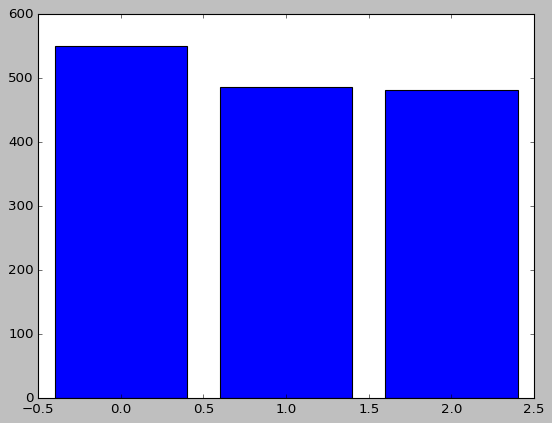

In [39]:
plt.bar(label_train, freq_train)

In [40]:
label_test, freq_test = np.unique(Y_test, return_counts=True)

<BarContainer object of 3 artists>

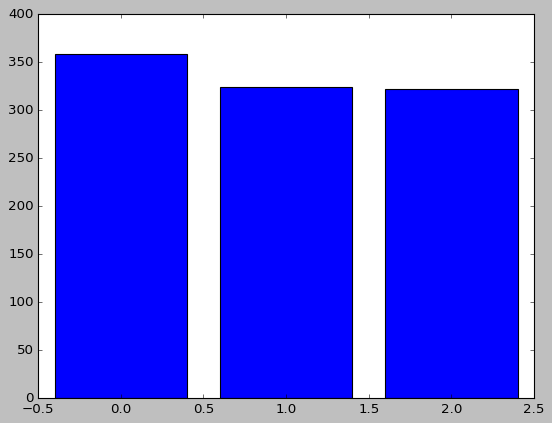

In [41]:
plt.bar(label_test, freq_test)

## 2. LDA

In [42]:
class LDA():
    def __init__(self, num_topics=5, chunksize=256, alpha=0.1, eta=0.1, iterations=100):
        self.ckpts_dir = "output/LDA+ML/LDA_checkpoints"
        self.params = {'num_topics':num_topics, 'alpha':alpha, 'eta':eta, 'iterations':iterations}
        self.model = None

    def fit(self, X_train):
        self.X_train = X_train
        self.dictionary = Dictionary(text.split() for text in X_train)
        self.train_corpus = [self.dictionary.doc2bow(text.split()) for text in X_train] # (word_idx, freq_count)
        self.model = gensim.models.LdaMulticore(id2word=self.dictionary, minimum_probability=0.000, **self.params)
        self.model.update(self.train_corpus)
        return self

    def save(self, model_name='test'):
        os.makedirs(os.path.join(self.ckpts_dir, model_name), exist_ok=True)
        self.model.save(os.path.join(self.ckpts_dir, model_name, model_name))
    
    def load(self, model_name='test'):
        self.model = gensim.models.LdaMulticore.load(os.path.join(self.ckpts_dir, model_name, model_name))
        self.dictionary = self.model.id2word
        

    def predict(self, document:str):
        document = document.split()
        document = self.dictionary.doc2bow(document)
        
        topics =  self.model.get_document_topics(document)
        result = []
        for topic in topics:
            result.append(topic[1])
        return np.array(result)
    
    def score(self, *args, **kwargs):
        score_fn = CoherenceModel(model=self.model, texts=[text.split() for text in self.X_train], dictionary=self.dictionary, coherence='c_v')
        return score_fn.get_coherence()
    
    def get_params(self, deep=False):
        return self.params
    
    def set_params(self, **parameters):
        self.params = parameters
        return self

In [43]:
extractor = LDA(**{'num_topics':50, 'alpha':1.1, 'eta':0.5, 'iterations':1000})
extractor.fit(X_train)

In [44]:
extractor.score()

0.3168533604692472

In [45]:
X_train_features = [extractor.predict(x) for x in X_train]
X_test_features = [extractor.predict(x) for x in X_test]

## 3. Model Training and Evaluation

### SVM

In [14]:
classifier_1 = SVC()

SVC_params = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.1, 1.0, 5.0, 10.0]}
selector = GridSearchCV(classifier_1, SVC_params, scoring='f1_macro')
selector.fit(X_train_features, Y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1.0, 5.0, 10.0],
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='f1_macro')

In [15]:
classifier_1 = selector.best_estimator_

In [16]:
selector.best_params_

{'C': 1.0, 'kernel': 'rbf'}

In [17]:
selector.best_score_

0.532797915691491

In [18]:
Y_pred = classifier_1.predict(X_test_features)
precision_recall_fscore_support(Y_test, Y_pred)

(array([0.60244648, 0.52978056, 0.5       ]),
 array([0.55027933, 0.52321981, 0.55451713]),
 array([0.57518248, 0.52647975, 0.52584934]),
 array([358, 323, 321], dtype=int64))

In [34]:
accuracy1 = accuracy_score(Y_test, Y_pred)
print("SVM Accuracy:", accuracy1)

print("Classification Report:")
print(classification_report(Y_test, Y_pred))

print("Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred))


SVM Accuracy: 0.5429141716566867
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.55      0.58       358
           1       0.53      0.52      0.53       323
           2       0.50      0.55      0.53       321

    accuracy                           0.54      1002
   macro avg       0.54      0.54      0.54      1002
weighted avg       0.55      0.54      0.54      1002

Confusion Matrix:
[[197  70  91]
 [ 67 169  87]
 [ 63  80 178]]


### Random Forest

In [20]:
classifier_2 = RandomForestClassifier()
RF_params = {'n_estimators':[300, 400, 450, 500, 550], 'criterion':['gini'], 'random_state':[SEED], 'max_depth':[17, 20, 22, 25, 27, 30],'max_features':['log2', 'sqrt']}
selector_2 = GridSearchCV(classifier_2, RF_params, scoring='f1_macro')
selector_2.fit(X_train_features, Y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'],
                         'max_depth': [17, 20, 22, 25, 27, 30],
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': [300, 400, 450, 500, 550],
                         'random_state': [19]},
             scoring='f1_macro')

In [21]:
selector_2.best_params_

{'criterion': 'gini',
 'max_depth': 17,
 'max_features': 'sqrt',
 'n_estimators': 400,
 'random_state': 19}

In [22]:
selector_2.best_score_

0.5165136643129075

In [23]:
classifier_2 = selector_2.best_estimator_

In [24]:
Y_pred_2 = classifier_2.predict(X_test_features)
precision_recall_fscore_support(Y_test, Y_pred_2)

(array([0.58469945, 0.52786885, 0.53172205]),
 array([0.59776536, 0.49845201, 0.5482866 ]),
 array([0.59116022, 0.51273885, 0.5398773 ]),
 array([358, 323, 321], dtype=int64))

In [35]:
accuracy2 = accuracy_score(Y_test, Y_pred_2)
print("RF Accuracy:", accuracy2)

print("Classification Report:")
print(classification_report(Y_test, Y_pred_2))

print("Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred_2))

RF Accuracy: 0.5499001996007984
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       358
           1       0.53      0.50      0.51       323
           2       0.53      0.55      0.54       321

    accuracy                           0.55      1002
   macro avg       0.55      0.55      0.55      1002
weighted avg       0.55      0.55      0.55      1002

Confusion Matrix:
[[214  67  77]
 [ 84 161  78]
 [ 68  77 176]]


### Adaptive Boosting (with base Decision Tree)

In [48]:
base_estimator = DecisionTreeClassifier(max_depth=18, max_features='log2', random_state=SEED, min_samples_leaf=5)
classifier_3 = AdaBoostClassifier(base_estimator=base_estimator, random_state=SEED, algorithm='SAMME.R')
Ada_params = {'n_estimators':[650, 700], 'learning_rate':[0.001]}
selector_3 = GridSearchCV(classifier_3, Ada_params, scoring='f1_macro')
selector_3.fit(X_train_features, Y_train)

c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site

GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=18,
                                                                                max_features='log2',
                                                                                min_samples_leaf=5,
                                                                                random_state=19),
                                          random_state=19),
             param_grid={'learning_rate': [0.001], 'n_estimators': [650, 700]},
             scoring='f1_macro')

In [49]:
selector_3.best_score_

0.4596174576611614

In [50]:
classifier_3 = selector_3.best_estimator_

In [51]:
Y_pred_3 = classifier_3.predict(X_test_features)
precision_recall_fscore_support(Y_test, Y_pred_3)

(array([0.48692153, 0.54854369, 0.4916388 ]),
 array([0.67597765, 0.3498452 , 0.45794393]),
 array([0.56608187, 0.42722117, 0.47419355]),
 array([358, 323, 321], dtype=int64))

In [52]:
accuracy3 = accuracy_score(Y_test, Y_pred_3)
print("Adaboost Accuracy:", accuracy3)

print("Classification Report:")
print(classification_report(Y_test, Y_pred_3))

print("Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred_3))

Adaboost Accuracy: 0.500998003992016
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.68      0.57       358
           1       0.55      0.35      0.43       323
           2       0.49      0.46      0.47       321

    accuracy                           0.50      1002
   macro avg       0.51      0.49      0.49      1002
weighted avg       0.51      0.50      0.49      1002

Confusion Matrix:
[[242  44  72]
 [130 113  80]
 [125  49 147]]
